In [1]:
!pip install yfinance ta

     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=6c7e1b0ad894c0b1b4d6e0ce8e8dec73c0208ed1127509e613b71e79bae9a0ba
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import load_model
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [3]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Colab Notebooks/COMP5513'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Colab Notebooks/COMP5513"


In [4]:
model = load_model('lstm-cnn.h5')

In [5]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [6]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['macd'] = macd.macd()
stock_data['macd_signal'] = macd.macd_signal()
stock_data['rsi'] = rsi.rsi()
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['ichimoku_a'] = ichi.ichimoku_a()
stock_data['ichimoku_b'] = ichi.ichimoku_b()
stock_data['ichimoku_base_line'] = ichi.ichimoku_base_line()
stock_data['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
stock_data = stock_data.fillna(0)

#stock_data = stock_data[:-1]
stock_orig = stock_data.copy()

#stock = stock[250:]
stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,27.730000,27.730000,27.730000,27.730000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.730,0.00,0.00
2008-01-03,27.059999,27.059999,27.059999,27.059999,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-04,27.690001,27.690001,27.690001,27.690001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-07,27.350000,27.350000,27.350000,27.350000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-08,27.280001,27.280001,27.280001,27.280001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,24.959999,25.100000,24.879999,25.020000,161166266,0.229421,0.166235,60.386143,24.529,25.305399,23.752601,24.205,23.990,24.01,24.40
2022-02-14,24.820000,24.879999,24.620001,24.680000,117839230,0.217566,0.176502,54.406696,24.538,25.317015,23.758985,24.205,23.990,24.01,24.40
2022-02-15,24.600000,24.719999,24.360001,24.459999,97270099,0.188249,0.178851,50.894904,24.533,25.312669,23.753331,24.295,23.990,24.01,24.58


In [7]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values

stock_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,0.827761,0.729317,0.749538,0.742674,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.793402,0.000000,0.000000
2008-01-03,0.807761,0.699191,0.718577,0.711996,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-04,0.826567,0.727518,0.747689,0.740843,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-07,0.816418,0.712230,0.731978,0.725275,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
2008-01-08,0.814328,0.709083,0.728743,0.722070,0.000000,0.640635,0.624379,0.000000,0.000000,0.000000,0.000000,0.000000,0.775284,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,0.745075,0.611061,0.617837,0.618590,0.410802,0.729144,0.695957,0.673998,0.757360,0.733617,0.766290,0.745630,0.591130,0.747975,0.736604
2022-02-14,0.740896,0.601169,0.605823,0.603022,0.300364,0.724571,0.700377,0.607258,0.757638,0.733954,0.766496,0.745630,0.591130,0.747975,0.736604
2022-02-15,0.734328,0.593975,0.593808,0.592949,0.247935,0.713260,0.701389,0.568062,0.757484,0.733828,0.766314,0.748402,0.591130,0.747975,0.742038


In [8]:
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line'],1)

features = 11 #including the close price

window_size = 60
week = 7
X = []
Y = []
print(stock_final)
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)
len_t = len(train_X)
# train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2,shuffle=True)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
# valid_label = np.array(valid_label)
# valid_X = np.array(valid_X)
train_X = train_X.reshape(train_X.shape[0],features,window_size,1)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


                High       Low  ...  ichimoku_b  ichimoku_base_line
Date                            ...                                
2008-01-02  0.729317  0.749538  ...    0.793402            0.000000
2008-01-03  0.699191  0.718577  ...    0.775284            0.000000
2008-01-04  0.727518  0.747689  ...    0.775284            0.000000
2008-01-07  0.712230  0.731978  ...    0.775284            0.000000
2008-01-08  0.709083  0.728743  ...    0.775284            0.000000
...              ...       ...  ...         ...                 ...
2022-02-11  0.611061  0.617837  ...    0.591130            0.747975
2022-02-14  0.601169  0.605823  ...    0.591130            0.747975
2022-02-15  0.593975  0.593808  ...    0.591130            0.747975
2022-02-16  0.602068  0.608595  ...    0.591130            0.754517
2022-02-17  0.607464  0.607671  ...    0.591130            0.758567

[3486 rows x 11 columns]


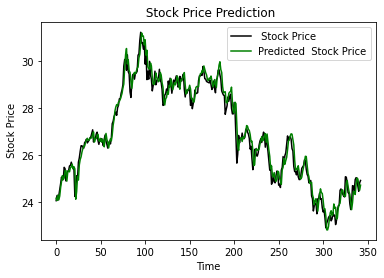

In [9]:
predicted  = model.predict(test_X)

real_price = y_scaler.inverse_transform(test_label[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [11]:
len_t = len(test_label)
len_t

343

In [12]:
len(predicted)

343

In [13]:
testing_data = stock_orig.iloc[-344:,:]

In [ ]:
testing_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2020-09-24,24.340000,24.360001,23.980000,24.120001,134397017,-0.316285,-0.185573,27.277173,25.299,26.294628,24.303372,25.039999,25.28,25.27,24.809999
2020-09-25,24.219999,24.280001,23.900000,24.059999,77083932,-0.362198,-0.220898,26.638798,25.196,26.254799,24.137201,25.000000,25.23,25.23,24.770000
2020-09-28,24.240000,24.299999,24.020000,24.280001,79254256,-0.376493,-0.252017,32.844702,25.118,26.205006,24.030993,25.000000,25.23,25.23,24.770000
2020-09-29,24.340000,24.340000,24.020000,24.080000,70395345,-0.399356,-0.281485,30.332588,25.028,26.145382,23.910618,24.960000,25.23,25.23,24.690000
2020-09-30,24.200001,24.580000,24.139999,24.280001,56320305,-0.396764,-0.304541,35.634267,24.951,26.051580,23.850420,24.930000,25.23,25.23,24.630000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,24.959999,25.100000,24.879999,25.020000,161166266,0.229421,0.166235,60.386143,24.529,25.305399,23.752601,24.205000,23.99,24.01,24.400000
2022-02-14,24.820000,24.879999,24.620001,24.680000,117839230,0.217566,0.176502,54.406696,24.538,25.317015,23.758985,24.205000,23.99,24.01,24.400000
2022-02-15,24.600000,24.719999,24.360001,24.459999,97270099,0.188249,0.178851,50.894904,24.533,25.312669,23.753331,24.295000,23.99,24.01,24.580000


In [14]:
real_price[0]

array([24.05999947])

In [66]:
def rsi_signal(rsi):
  rsi_val = float(rsi)
  if rsi_val >= 70:
    return -1
  if rsi_val <= 30:
    return 1
  else:
    return 0

def predict_signal(current, predict, threshold=0.013):
  diff = (current - predict)/current
  # print(diff)
  if abs(diff) >= threshold:
    if np.sign(diff) > 0:
      return -1
    else:
      return 1
  else:
    return 0

def trade(price, capital, state, stock, rsi, macd, ml, threshold=0.6, min_lot=500):
  remain = 0
  score = rsi*0.3+macd*0.3+ml*0.4
  if score > threshold and state != 1:
    lots = math.floor(capital / (price*min_lot))
    amount = price * lots * min_lot
    if lots > 1 and capital > amount:
      remain = capital - amount
    else:
      return None, None, None
    return remain, lots, 1
  elif score <= -0.3 and state != 0:
    values = capital + price * stock * min_lot
    return values, 0, 0
  else:
    return None, None, None

def macd_signal(macd, prev_macd, signal, prev_signal):
  if prev_signal > prev_macd and signal < macd:
    return 1
  elif prev_signal < prev_macd and signal > macd:
    return -1
  else:
    return 0

In [53]:
trade(25.4,200000, 0, 0, -1,0,0)

(None, None, None)

In [65]:
money_sequence = []
count = 0
init_capital = 1000000
init_state = 0
init_stock = 0
cash_in_hand = init_capital
p_signal = 0
p_macd = 0
money_sequence.append(cash_in_hand)
for index, row in testing_data.iterrows():
  if count == 0:
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1
    continue
  if count < 343:
    rsi_sig = rsi_signal(row['rsi'])
    ml_sig = predict_signal(row['Close'], predicted[count][0])
    macd_sig = macd_signal(row['macd'], p_macd, row['macd_signal'], p_signal)
    remain, lots, state = trade(row['Close'],cash_in_hand, init_state, init_stock, rsi_sig,macd_sig,ml_sig)
    if (remain != None):
      cash_in_hand = remain
      init_state = state
      init_stock = lots
      print(index, row['Close'], cash_in_hand, init_state, init_stock)
    if state == 0:
      money_sequence.append(remain)
    # print(row['rsi'], row['macd'], p_macd, row['macd_signal'], p_signal, rsi_sig, ml_sig, macd_sig)
    p_signal = row['macd_signal']
    p_macd = row['macd']
    count += 1

money_sequence

2021-07-27 00:00:00 25.65999984741211 12090.005874633789 1 77
2021-09-15 00:00:00 25.780000686645508 1004620.0323104858 0 0


[1000000, 1004620.0323104858]

In [ ]:
predicted

array([[24.16392 ],
       [24.068192],
       [24.300209],
       [24.096827],
       [24.256882],
       [24.616606],
       [24.867712],
       [25.12545 ],
       [24.955954],
       [25.031094],
       [25.338182],
       [25.346016],
       [24.891863],
       [25.268997],
       [25.346136],
       [25.287874],
       [25.479088],
       [25.49472 ],
       [25.612791],
       [25.41392 ],
       [25.507133],
       [25.412764],
       [24.120764],
       [24.44076 ],
       [25.095995],
       [24.937382],
       [25.583384],
       [25.81255 ],
       [25.929216],
       [26.13536 ],
       [26.280031],
       [26.388748],
       [26.384836],
       [26.539145],
       [26.63659 ],
       [26.71852 ],
       [26.633627],
       [26.644653],
       [26.718739],
       [26.72103 ],
       [26.747774],
       [26.903427],
       [26.990881],
       [26.560852],
       [26.682423],
       [26.710472],
       [26.865213],
       [26.888268],
       [26.616852],
       [26.58799 ],


In [ ]:
for i in real_price:
  print(i[0])

24.059999465942383
24.28000068664551
24.079999923706055
24.28000068664551
24.520000457763672
24.780000686645508
25.059999465942383
24.940000534057617
24.979999542236328
25.479999542236328
25.42000007629395
24.899999618530273
25.20000076293945
25.319999694824222
25.340000152587894
25.540000915527344
25.559999465942383
25.700000762939453
25.520000457763672
25.459999084472656
25.379999160766605
24.23999977111816
24.600000381469727
25.1200008392334
25.0
25.700000762939453
25.8799991607666
26.15999984741211
26.399999618530277
26.399999618530277
26.340000152587894
26.299999237060543
26.540000915527344
26.579999923706055
26.68000030517578
26.520000457763672
26.579999923706055
26.639999389648438
26.739999771118164
26.780000686645508
26.940000534057617
27.079999923706055
26.559999465942383
26.719999313354492
26.68000030517578
26.899999618530273
26.979999542236328
26.6200008392334
26.45999908447266
26.68000030517578
26.600000381469727
26.700000762939453
26.579999923706055
26.399999618530277
26.6